# Tutorial project for Kria KV260 - Image processing with OpenCV IP Cores
---

Author: F.Kesel, 20.8.2024

In this Jupyter Notebook, which runs on a Kria KV260, the convolution IP Core is tested using a sample image or an image from the webcam. 

* The following files are needed in the project directory on the Zedboard:
   * Bitfile (Vitis): `conv_hw.xclbin`
   * Image files: The image file which has been used to test the HLS IP core in bmp-format.
* The purpose of the first cell is to set the filter matrix values. Next the file names for the input image and the result image are set. Furthermore the bitfile name is defined. If you want to have some more debugging output, then set the `debug_flag = 1`. 
* Note that if you used parallel execution in the HLS kernel, then the width of input image must be a multiple of 8. 
* The notebook uses some python modules from a local directory (see next cell). Make sure that the path to this directory fits your system. 
   

In [122]:
# Import the necessary libraries and modules
import numpy as np
import cv2 as cv
import time
from matplotlib import pyplot as plt
# Import pynq library
from pynq import allocate, Overlay
# Import modules from utilities directory
import sys
sys.path.append("/home/root/jupyter_notebooks/projects/utils/")
import perftimer as pt
import hls_ip as ip

# Define filter kernel (data format is 16 Bit integer)
#filter = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.int16) ##Identity matrix
#filter = np.array([[0,1,0], [1,-4,1], [0,1,0]], dtype=np.int16) #Laplace Filter (Edge detection)
filter = np.array([[1,0,-1], [2,0,-2], [1,0,-1]], dtype=np.int16) #Sobel Filter (Edge detection)

#Define project path
project_path = "/home/ubuntu/projects/hw/convolution/"

# Input sample image (1080x1920)
image_file_name = project_path + "images/image_1920x1080.bmp"

# Result image
result_image_file_name = project_path + "images/result_hd.bmp"

#Define bitfile name (located in the same folder as this notebook)
bitfile = project_path + "conv_hw.xclbin"

# Set debug flag to 1 for debug prints
debug_flag = 0

# Image size (HD) for Brio Cam
frame_in_w = 1920
frame_in_h = 1080

# Define if usb cam image is used (=1) or sample image (=0)
use_cam = 1

In the next cell the input image is read either from the webcam or the sample image is used.

Capture device successfully opened!
Frame successfully captured!


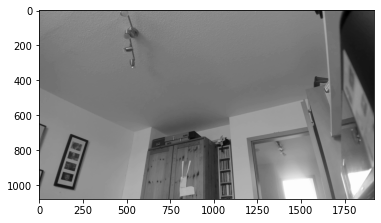

In [123]:
# initialize camera from OpenCV (must be on /dev/video0)
if use_cam == 1:
    videoIn = cv.VideoCapture(0 + cv.CAP_V4L2)
    videoIn.set(cv.CAP_PROP_FRAME_WIDTH, frame_in_w);
    videoIn.set(cv.CAP_PROP_FRAME_HEIGHT, frame_in_h);
    if videoIn.isOpened() == True:
        print("Capture device successfully opened!")
    # Capture webcam frame
    ret, frame = videoIn.read()
    if ret == True:
        print("Frame successfully captured!")
    # Release camera
    videoIn.release()
    # Convert to grayscale image for HW processing by the HLS kernel
    img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
# Read sample input image instead of cam 
else:
    img = cv.imread(image_file_name, cv.IMREAD_GRAYSCALE) #Read image in grayscale

if debug_flag == 1:
    print("Image shape:", img.shape)
    print("Image data type: ", img.dtype)
    
# Show the image with matplotlib
plt.imshow(img, cmap='gray')
plt.show()

# Get size of input image
(rows, cols) = img.shape
size = rows * cols

# Reshape input image to a vector
img_vector = img.reshape(size)

The next cell loads the so called overlay, which means basically loading the bitfile into the PL of the Zynq. You can get informations, what's inside the overlay if the `debug_flag`is set (a new window will open up below). 

In [124]:
# Load bitfile in pynq overlay
conv_design = Overlay(bitfile)
if debug_flag == 1:
    help(conv_design)

The IP core `conv_top_1` in the overlay is associated with a driver called `conv_ip`. Please note that the name of the IP core might change, depending on the instance name given in Vitis. The register map of the IP core is shown, it should match with the registers in your HLS design!

In [125]:
# Associate IP core with default driver named "conv_ip"
conv_ip = conv_design.conv_top_1

# Show register map of IP core: Check that the register names match in the following cells!
if debug_flag == 1:
    conv_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0, AP_CONTINUE=0),
  in_image = Register(value=0),
  out_image = Register(value=0),
  filter = Register(value=0),
  height = Register(value=0),
  width = Register(value=0)
}

In the next cell buffers for input and output images and the filter matrix in main memory are allocated as arrays with the image size defined above and data type of 8 Bit unsigned integer. The filter matrix has a data type of int16 and a fixed size of 9. The input image is written to the input buffer and the output buffer is cleared. The filter buffer is loaded with the coefficients given above (converted to a vector). 

In [126]:
#Allocate buffers in memory accessible by IP core
input_buffer = allocate(shape=(size,), dtype=np.uint8)
output_buffer = allocate(shape=(size,), dtype=np.uint8)
filter_buffer = allocate(shape=(9,), dtype=np.int16)
filt_vec = filter.reshape(9)

#Fill memory buffers
input_buffer[:] = img_vector[:]
output_buffer[:] = 0
#Fill filter matrix    
filter_buffer[:] = filt_vec[:]

In the next cell the DMA registers for input and output image and the filter matrix are written with the addresses of the buffers defined above.

In [127]:
# Load DMA registers with addresses of buffers
conv_ip.register_map.in_image = input_buffer.device_address
conv_ip.register_map.out_image = output_buffer.device_address
conv_ip.register_map.filter = filter_buffer.device_address
# Set the size of the image
conv_ip.register_map.height = rows
conv_ip.register_map.width = cols

In the next cell the IP Core is run and execution time for the kernel is measured. The IP core is run by the function `run_ip` from the module `hls_ip` (see Python script `hls_ip.py`).  The result should now be in the output buffer `output_buffer`in main memory. The output buffer is reshaped to matrix format and copied to the `result_image`. 

In [128]:
# Initialize a timer
hw_timer = pt.Timer("Execution time HW:", True)
# Start timer
hw_timer.start()
# Run the IP
ip.run_ip(conv_ip)
# Stop timer
hw_timer.stop()
# Write output image
result_image = output_buffer.reshape(rows,cols)

Execution time HW: elapsed time: 2286.023 us


In the last cell the result image is shown and the result is written to a file.

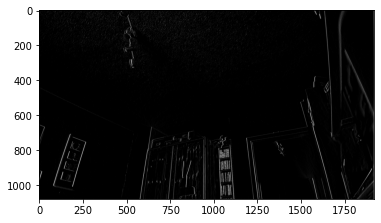

True

In [129]:
# Show the image with matplotlib
plt.imshow(result_image, cmap='gray')
plt.show()
# Write result + ref image
cv.imwrite(result_image_file_name, result_image)